In [1]:

import pandas as pd
from My_factors_raw import Factor

import sys
sys.path = ['/data/xianliang/project_ctaintern/']+sys.path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import pickle
import pyelf.elutil as eu
import pyelf.commodity_list as commlist
import Tools.MLTools as mltool
from pandarallel import pandarallel
import talib as tb

%matplotlib inline


outdir = '/data/yechen/project_ctaintern/CTA_Demo/factor_test_freq/'
mltool.myMakeDir(outdir)
figpath = os.path.join(outdir, 'FactorExploration')

In [2]:
'''
使用指数数据产生交易信号, 主力后复权数据回测
'''
periods = [5,30, 60, 120,480]
cperiod = 5
dayed_time = datetime.time(15,0)
comms = commlist.comms_all
date_b = datetime.datetime(2016,1,1)

for period in periods:
    datadir = '/data/yechen/project_ctaintern/data2016_left/index/'
    locals()[f'data_index_{period}min'] = mltool.CTA_LoadData_AutoFactor(datadir,period,aux_cols=['if_jy','amount','twap','vwap'],date_b=date_b,cols=comms,ref_ind=None,if_parquet=True)

    datadir = '/data/yechen/project_ctaintern/data2016_left/zl/'
    locals()[f'data_zl_{period}min'] = mltool.CTA_LoadData_AutoFactor(datadir,period,aux_cols=['if_jy','amount','twap','vwap'],date_b=date_b,cols=comms,ref_ind=None,if_parquet=True)

In [3]:

def ResampleDataToDay(data_dict, cperiod=0,twap_periods=[1,3,6,12]):
    dfmin = data_dict['C'].copy()
    idf = dfmin.copy()
    cols_ = idf.columns
    idf['index'] = idf.index
    idf['indexC'] = [ix+datetime.timedelta(minutes=cperiod) for ix in idf.index]
    idf['tn'] = eu.get_timenum(idf.index)
    idf['day_clabel'] = 0
    idf.loc[((idf['tn'].shift(-1)>200000) & (idf['tn']<160000) & (idf['tn']>140000)), 'day_clabel'] = 1
    idf.loc[((idf['tn'].shift(-1)<=90000) & (idf['tn']<160000) & (idf['tn']>140000)), 'day_clabel'] = 1
    idf['day_olabel'] = idf['day_clabel'].shift(1)
    idf.loc[idf.index[0], 'day_olabel'] = 1
    idf['day_clabel'] = idf['day_clabel'].cumsum()
    idf['day_olabel'] = idf['day_olabel'].cumsum()

    indexC = idf['indexC'].groupby(idf['day_olabel']).last()

    tmp_dict = {}
    for icol in list(data_dict.keys()):
        if icol=='period':
            tmp_dict['period'] = 1440
        else:
            tmpdf = data_dict[icol].copy()
            if icol in ['C','twap','if_jy']:
                tmpdf = tmpdf[cols_].groupby(idf['day_olabel']).last()
            elif icol in ['V','amount']:
                tmpdf = tmpdf[cols_].groupby(idf['day_olabel']).sum()
            elif icol in ['O']:
                tmpdf = tmpdf[cols_].groupby(idf['day_olabel']).first()
            elif icol in ['H']:
                tmpdf = tmpdf[cols_].groupby(idf['day_olabel']).max()
            elif icol in ['L']:
                tmpdf = tmpdf[cols_].groupby(idf['day_olabel']).min()
            elif icol in ['vwap']:
                tmpdf1 = data_dict['vwap'].copy()
                tmpdf2 = data_dict['V'].copy()
                tmpdf = (tmpdf1[cols_]*tmpdf2[cols_]).groupby(idf['day_olabel']).sum()/tmpdf2[cols_].groupby(idf['day_olabel']).sum()
            else:
                tmpdf = tmpdf[cols_].groupby(idf['day_olabel']).last()
            tmpdf.index = indexC

            tmp_dict[icol] = tmpdf
            
    for twap_period in twap_periods:
        tmpdf = (data_dict['twap'].copy()).groupby(idf['day_olabel']).apply(lambda x:x.iloc[:twap_period,:].mean())
        tmpdf.index = indexC
        tmp_dict[f'open_twap_{twap_period*5}'] = tmpdf
            
    return tmp_dict


def DnSample(df_day, df_min, fillna_val=1):
    uindex = df_day.index.union(df_min.index)
    df_day_new = df_day.reindex(uindex).fillna(method='ffill').fillna(fillna_val)
    return df_day_new.reindex(df_min.index)


def rev_ma(data, xp):
    cdf = data['C']
    day_CC1 = data['day_CC1']
    data_day = data['daily_data']
    bias_day = data_day['C']/data_day['C'].rolling(window=xp).mean()-1

    zperiod = 12*21
    bias_day_zs = Zscore(bias_day, zperiod)
    bias_day_zs_min = DnSample(bias_day_zs, cdf, fillna_val=0)

    revdf = KNZscore(cdf/day_CC1, zperiod)-bias_day_zs_min

    nameflag_ = 'rev_ma%d'%xp

    return revdf, nameflag_

In [4]:
'''
使用指数数据产生交易信号, 主力后复权数据回测,生成日线数据
'''

data_zl_day = ResampleDataToDay(data_zl_5min, cperiod=5,twap_periods= [1,3,6,12])
data_index_day = ResampleDataToDay(data_index_5min, cperiod=5,twap_periods=[1,3,6,12])


In [5]:
class ArbTwo:
    '''
    实现2品种 价差对/比价, 并设置真实交易手数
    ex: pp-3ma 产生价差对, 交易设置 2pp vs 3ma
    '''
    def __init__(self):
        self.name = ''
        self.symbol1 = 'pp'
        self.symbol2 = 'ma'
        self.ratio1 = 1 
        self.ratio2 = 3
        self.arblogic = 'sub' ### sub: pp-3ma; div: pp/3ma
        self.lots_mode = 0 ### 0-rebalance lots every trade; 1-use lots1, lots2 pre-defined
        self.lots1 = 2
        self.lots2 = 3

    def set_para(self, symbol1, symbol2, ratio1=1, ratio2=1, arblogic='sub', lots_mode=0, lots1=1, lots2 = 1):
        self.name = '%s-%s'%(symbol1, symbol2) if arblogic=='sub' else '%s/%s'%(symbol1, symbol2)
        self.symbol1 = symbol1
        self.symbol2 = symbol2
        self.ratio1 = ratio1 
        self.ratio2 = ratio2
        self.arblogic = arblogic
        self.lots_mode = lots_mode
        self.lots1 = lots1
        self.lots2 = lots2


arbtwo_list = list()

pair1 = ArbTwo()
pair1.set_para('hc','rb',1,1,'sub',1,1,1)

# pair2 = ArbTwo()
# pair2.set_para('rb','i',1,1,'div',0)

pair2 = ArbTwo()
pair2.set_para('c','cs',1,1,'sub',1,1,1)

# pair4 = ArbTwo()
# pair4.set_para('yy','m',1,1,'div',0)

# pair5 = ArbTwo()
# pair5.set_para('oi','rm',1,1,'div',0)

pair3 = ArbTwo()
pair3.set_para('m','rm',1,1,'sub',1,1,1)

pair4 = ArbTwo()
pair4.set_para('oi','yy',1,1,'sub',1,1,1)

pair5 = ArbTwo()
pair5.set_para('yy','p',1,1,'sub',1,1,1)

# pair9 = ArbTwo()
# pair9.set_para('ss','ni',1,1,'div',0)

pair6 = ArbTwo()
pair6.set_para('pp','ma',1,3,'sub',1,2,3)

# pair11 = ArbTwo()
# pair11.set_para('pf','ta',1,1,'div',0)

pair7 = ArbTwo()
pair7.set_para('lu','fu',1,1,'sub',1,1,1)

pair8 = ArbTwo()
pair8.set_para('ru','nr',1,1,'sub',1,1,1)

pair9 = ArbTwo()
pair9.set_para('pp','l',1,1,'sub',1,1,1)

arbtwo_list.append(pair1)
arbtwo_list.append(pair2)
arbtwo_list.append(pair3)
arbtwo_list.append(pair4)
arbtwo_list.append(pair5)
arbtwo_list.append(pair6)

# arbtwo_list.append(pair7)
# arbtwo_list.append(pair8)
arbtwo_list.append(pair9)
# arbtwo_list.append(pair10)
# arbtwo_list.append(pair11)
# arbtwo_list.append(pair12)
# arbtwo_list.append(pair13)
# arbtwo_list.append(pair14)

In [6]:

def GenerateArbData(pair:ArbTwo, data):
    arbdata_dict = {}
    arbdata_dict['name'] = pair.name
    for icol in ['O','H','L','C']:
        if icol == 'C':
            arbdata_dict[f'{icol}_add'] = pair.ratio1*data[icol][pair.symbol1] - pair.ratio2*data[icol][pair.symbol2]
        if pair.arblogic=='sub':
            arbdata_dict[icol] = pair.ratio1*data[icol][pair.symbol1]-pair.ratio2*data[icol][pair.symbol2]

        elif pair.arblogic=='div':
            arbdata_dict[icol] = (pair.ratio1*data[icol][pair.symbol1])/(pair.ratio2*data[icol][pair.symbol2])
        
    for icol in ['O','H','L','C','V','I','amount','twap','vwap']:
         arbdata_dict[f'{icol}_1'] = pair.ratio1*data[icol][pair.symbol1]
         arbdata_dict[f'{icol}_2'] = pair.ratio2*data[icol][pair.symbol2]
    
    return arbdata_dict


def hedge_ratio(series_y,series_x,period,maperiod=1):
    beta  =  series_y.rolling(period).cov(series_x) / series_x.rolling(period).var()
    avg_y = series_y.rolling(period).mean()
    avg_x = series_x.rolling(period).mean()
    alpha = avg_y - beta*avg_x
    res = series_y - (beta.ewm(maperiod).mean() * series_x + alpha.ewm(maperiod).mean())
    
    return res,beta
    


def GenerateArbData_roll(pair:ArbTwo, data, roll_period = 64,maperiod=1):
    
    arbdata_dict = {}
    arbdata_dict['name'] = pair.name
    for icol in ['O','H','L','C']:
        if pair.arblogic=='sub':
            arbdata_dict[icol] = hedge_ratio(pair.ratio1*data[icol][pair.symbol1],pair.ratio2*data[icol][pair.symbol2],period=roll_period,maperiod=maperiod)

        elif pair.arblogic=='div':
            arbdata_dict[icol] = (pair.ratio1*data[icol][pair.symbol1])/(pair.ratio2*data[icol][pair.symbol2])
        
    for icol in ['O','H','L','C','V','I','amount','twap','vwap']:
         arbdata_dict[f'{icol}_1'] = pair.ratio1*data[icol][pair.symbol1]
         arbdata_dict[f'{icol}_2'] = pair.ratio2*data[icol][pair.symbol2]
    
    
    return arbdata_dict

def GenerateArbData_trade(pair:ArbTwo, data, trade_freqs = [5,15,30,60]):
    arbdata_dict = {}
    arbdata_dict['name'] = pair.name
    
    for icol in ['O','H','L','C','V','I','amount','twap','vwap']:
        arbdata_dict[f'{icol}_1'] = data[icol][pair.symbol1]
        arbdata_dict[f'{icol}_2'] = data[icol][pair.symbol2]
    
    ret_1 = (arbdata_dict['C_1'].shift(-1) - arbdata_dict['C_1'])/arbdata_dict['C_1']
    ret_2 = (arbdata_dict['C_2'].shift(-1) - arbdata_dict['C_2'])/arbdata_dict['C_2']
    
    if eu.get_timenum(data['C'][pair.symbol1].index).mean() == 15*10000:
        for freq in trade_freqs:
            arbdata_dict[f'ret_twap_{freq}'] = (data[f'open_twap_{freq}'][pair.symbol1].shift(-2) - data[f'open_twap_{freq}'][pair.symbol1].shift(-1))/data[f'open_twap_{freq}'][pair.symbol1].shift(-1) - (data[f'open_twap_{freq}'][pair.symbol2].shift(-2) - data[f'open_twap_{freq}'][pair.symbol2].shift(-1))/data[f'open_twap_{freq}'][pair.symbol2].shift(-1)    

    
    if pair.arblogic=='sub':
        arbdata_dict['C'] = pair.ratio1*data['C'][pair.symbol1] - pair.ratio2*data['C'][pair.symbol2]
    elif pair.arblogic=='div':
        arbdata_dict['C'] = (pair.ratio1*data['C'][pair.symbol1])/(pair.ratio2*data['C'][pair.symbol2])
    
    
    arbdata_dict['if_jy'] = data['if_jy'][pair.symbol1] * data['if_jy'][pair.symbol2]
    
    arbdata_dict['ret'] = ret_1 - ret_2

    
    
    return arbdata_dict

def GenerateArbData_ret(pair:ArbTwo, data, freqs_list = [1,6,12,36]):
    arbdata_dict = {}
    arbdata_dict['name'] = pair.name
    
    for freq in freqs_list:
        ret_1 = (pair.ratio1*data['C'][pair.symbol1].shift(-freq) - pair.ratio1*data['C'][pair.symbol1])/(pair.ratio1*data['C'][pair.symbol1])
        ret_2 = (pair.ratio2*data['C'][pair.symbol2].shift(-freq) - pair.ratio2*data['C'][pair.symbol2])/(pair.ratio2*data['C'][pair.symbol2])
        arbdata_dict[f'ret_{freq}'] = ret_1 - ret_2
    
    return arbdata_dict


In [7]:
class Factor_index:
    def __init__(self,data):
        self.data = {}
        names = list(data[0].keys())[1:]
        for name in names:
            self.data[name] = pd.DataFrame()
            for p in data:
                self.data[name][p['name']] = p[name]
        
    def ResampleDayCumFunc(self, df, cperiod, rule='sum', dayed_time=datetime.time(15,0)):
        idf = df.copy()
        cols_ = idf.columns.tolist()
        idf['index'] = idf.index
        idf['indexC'] = [ix+datetime.timedelta(minutes=cperiod) for ix in idf.index]

        shift = 0
        idf['day_clabel'] = 1*(idf['indexC'].apply(lambda x: x.time()) == dayed_time)
        idf['day_olabel'] = idf['day_clabel'].shift(1+shift)
        idf.loc[idf.index[0+shift], 'day_olabel'] = 1

        idf['kn'] = range(len(idf))
        idf['kn_open'] = np.nan
        idf.loc[idf['day_olabel']==1, 'kn_open'] = idf.loc[idf['day_olabel']==1, 'kn']
        idf['kn_open'] = idf['kn_open'].fillna(method='ffill')

        idf['kn'] = idf['kn']-idf['kn_open']

        idf['day_clabel'] = idf['day_clabel'].cumsum()
        idf['day_olabel'] = idf['day_olabel'].cumsum()
        idf['day_olabel'] = idf['day_olabel'].fillna(method='bfill')

        if rule=='sum':
            idf_out = idf[cols_].groupby(idf['day_olabel']).cumsum()
        elif rule=='max':
            idf_out = idf[cols_].groupby(idf['day_olabel']).cummax()
        elif rule=='min':
            idf_out = idf[cols_].groupby(idf['day_olabel']).cummin()
        elif rule=='count':
            idf_out = idf[cols_].groupby(idf['day_olabel']).cumcount()
        elif rule=='mean':
            idf_out = idf[cols_].groupby(idf['day_olabel']).cumsum().div(idf[cols_].groupby(idf['day_olabel']).cumcount(), axis=0)
        
        return idf_out


    def SignSR(self, xp):

        '''
        夏普因子
        :param xp:
        :return:
        '''
            
        cdf = self.data['C']
        ret1 = cdf.pct_change()
        srdf = ret1.rolling(window=xp,min_periods=1).mean()/ret1.rolling(window=xp,min_periods=1).std()
        nameflag_ = 'SignSR%d'%xp
        return -srdf, nameflag_



    
    
    
    
    
    
    def spread_reverpress_stats(self,xp):
        
        cdf = self.data['C']
        

        
        
        q_50 = cdf.rolling(window=xp,min_periods=1).quantile(0.5)
        q_25 = cdf.rolling(window=xp,min_periods=1).quantile(0.25)
        q_75 = cdf.rolling(window=xp,min_periods=1).quantile(0.75)
        q_01 = cdf.rolling(window=xp,min_periods=1).quantile(0.01)
        q_99 = cdf.rolling(window=xp,min_periods=1).quantile(0.99)
        

        required_1 = (cdf < (q_01 - 0.1*(q_50-q_01))) 
        required_1_ = (cdf > (q_99 + 0.1*(q_99-q_50))) 
        required_2 = (cdf > q_75) & (cdf <= (q_99 + 0.1*(q_99-q_50)))
        required_3 = (cdf < q_25) & (cdf <= (q_01 - 0.1*(q_50-q_01))) 
        required_4 = (cdf >= q_25) & (cdf <= q_50)
        required_5 = (cdf <= q_75) & (cdf > q_50)
        
        
        Mean = cdf.rolling(xp).quantile(0.5)
        Sigma = cdf.rolling(xp).std()
        spress_ = abs((cdf - Mean)/Sigma)
        
        
        spress = pd.DataFrame(index=cdf.index,columns=cdf.columns)
        spress[required_1] = (-0.5 * spress_[required_1])
        spress[required_1_] = (0.5 * spress_[required_1_])
        spress[required_2] = (-2 * spress_[required_2])
        spress[required_3] = (2 * spress_[required_3])
        spress[required_4] = (1 * spress_[required_4])
        spress[required_5] = (-1 * spress_[required_5])
        
        nameflag_ = 'spread_reverpress_stats%d'%xp
        
        return  spress,nameflag_
    
    def MeanMa(self,xp):
        C_1 = self.data['C_1'].copy()
        C_2 = self.data['C_2'].copy()
        Sigma_1 = C_1.rolling(window=xp).std()
        Sigma_2 = C_2.rolling(window=xp).std()
        ma_1 = (C_1/(C_1.rolling(window=xp).mean()))
        ma_2 = (C_2/(C_2.rolling(window=xp).mean()))
        Sigma = (Sigma_1 + Sigma_2)
        ma_diff = abs(ma_1 - ma_2)
        ma_diff[((ma_1>1)&(ma_2>1))|((ma_1<1)&(ma_2<1))] = 1.2 * ma_diff[((ma_1>1)&(ma_2>1))|((ma_1<1)&(ma_2<1))]
        ma_diff[((ma_1>1)&(ma_2<1))|((ma_1<1)&(ma_2>1))] = 0.8 * ma_diff[((ma_1>1)&(ma_2<1))|((ma_1<1)&(ma_2>1))]
        nameflag_ = 'MeanMa_std%d'%xp
        return ma_diff,nameflag_
        
        
    
    def spread_reverpress(self,xp):
        
        cdf = self.data['C']
        Mean = cdf.rolling(window=xp,min_periods=1).mean()
        Sigma = cdf.rolling(window=xp,min_periods=1).std()
        rp = -((cdf - Mean)/Sigma)
        nameflag_ = 'spread_reverpressa%d' % xp
        return  rp, nameflag_
    
    '''
    趋势度量指标
    '''
    def get_id(self,ts,signal):
        if signal ==1:
                return len(ts[:ts.idxmax()])
        else:
                return len(ts[:ts.idxmin()]) 


    def get_ratio(self,ts:pd.Series, xp):
    
        Max = ts.rolling(xp).max()
        max_id = ts.rolling(xp).apply(self.get_id, args=(1,))
        Min = ts.rolling(xp).min()
        min_id = ts.rolling(xp).apply(self.get_id, args=(0,))
        ts_id = xp
        
        k1 = abs(ts - Max)/((ts_id - max_id)+1) 
        k2 = abs(ts - Min)/((ts_id - min_id)+1) 
        ratio = np.maximum(k1,k2)
        
        return ratio
    
    
    def ma_ratio(self,xp,window):
        ma = self.data['C'].rolling(xp).mean()
        ratio = 1/ma.apply(self.get_ratio,args = (window,))
        nameflag_ = 'ma_ratio %d'%xp
        
        return ratio, nameflag_
    
    '''
    过去一段时间内涨跌幅最大的收益率之差
    '''
    def estsum(self,i_column, ccs, signal, xp, numb):
        cc = ccs[:, i_column]
        est = np.zeros(np.shape(cc))
        # 最大值signal=1，最小值signal=-1
        for j in range(xp, cc.shape[0]+1):
            jcc = cc[j-xp:j]
            jest = np.sum(np.partition(jcc, -1*signal*numb)[-1*signal*numb:])
            est[j-1] = jest
        return est.reshape(-1,1)

    def originpeak(self, xp):
        cdf = self.data['C_1']
        ret0 = cdf.pct_change().values
        allparas = range(ret0.shape[1])
        largest = eu.multiprocess(self.estsum, paras=allparas, n_processes=min(100, len(allparas)), ccs=ret0 ,signal=1, xp=xp, numb=4)
        smallest = eu.multiprocess(self.estsum, paras=allparas, n_processes=min(100, len(allparas)), ccs=ret0 ,signal=-1, xp=xp, numb=4)
        largedf = pd.DataFrame(np.concatenate(largest, axis=1), index=cdf.index, columns=cdf.columns)
        smalldf = pd.DataFrame(np.concatenate(smallest, axis=1), index=cdf.index, columns=cdf.columns)
        originpeakdf_1 = smalldf - largedf
        
        cdf = self.data['C_2']
        ret0 = cdf.pct_change().values
        allparas = range(ret0.shape[1])
        largest = eu.multiprocess(self.estsum, paras=allparas, n_processes=min(100, len(allparas)), ccs=ret0 ,signal=1, xp=xp, numb=4)
        smallest = eu.multiprocess(self.estsum, paras=allparas, n_processes=min(100, len(allparas)), ccs=ret0 ,signal=-1, xp=xp, numb=4)
        largedf = pd.DataFrame(np.concatenate(largest, axis=1), index=cdf.index, columns=cdf.columns)
        smalldf = pd.DataFrame(np.concatenate(smallest, axis=1), index=cdf.index, columns=cdf.columns)
        originpeakdf_2 = smalldf - largedf

        corr = self.data['C_1'].rolling(xp).corr(self.data['C_2'])
        
        originpeakdf = abs(originpeakdf_1 - originpeakdf_2) * corr
        nameflag_ = 'originpeak %d'%xp
        return originpeakdf, nameflag_

In [8]:
def dict2df(data):
    dic = {}
    names = list(data[0].keys())[1:]
    for name in names:
        dic[name] = pd.DataFrame()
        for p in data:
            dic[name][p['name']] = p[name]
    return dic

In [28]:
from typing import Tuple

def ArbBacktest_roll(para_bkt:Tuple[pd.Series, ArbTwo], data, beta, cost_penalty=0):
    ps_pair, pair = para_bkt
    psdf = pd.DataFrame(index=ps_pair.index)
    # if pair.lots_mode==0:
    psdf[pair.symbol1] = ps_pair/(1 + abs(beta))
    psdf[pair.symbol2] = -(beta)*ps_pair/(1 + abs(beta))

    scomms = [pair.symbol1, pair.symbol2]

    data_bkt = {}
    data_bkt['C'] = data['C'][scomms]

    dfbkt = mltool.GetMinProfit(psdf, data_bkt, scomms, cost_penalty=cost_penalty, if_pct=True)

    return dfbkt

Copula

In [9]:
def hedge_ratio(series_y,series_x,period,maperiod=1):
    beta  =  series_y.rolling(period).cov(series_x) / series_x.rolling(period).var()
    avg_y = series_y.rolling(period).mean()
    avg_x = series_x.rolling(period).mean()
    alpha = avg_y - beta*avg_x
    res = series_y - (beta.ewm(maperiod).mean() * series_x + alpha.ewm(maperiod).mean())
    
    return res,beta
    


def GenerateArbData_roll(pair:ArbTwo, data, roll_period = 21*6,maperiod=1):
    
    arbdata_dict = {}
    arbdata_dict['name'] = pair.name
    for icol in ['O','H','L','C']:
        if pair.arblogic=='sub':
            alpha, beta = hedge_ratio(pair.ratio1*data[icol][pair.symbol1],pair.ratio2*data[icol][pair.symbol2],period=roll_period,maperiod=maperiod)
            arbdata_dict[icol] = alpha

        elif pair.arblogic=='div':
            arbdata_dict[icol] = (pair.ratio1*data[icol][pair.symbol1])/(pair.ratio2*data[icol][pair.symbol2])
        
    for icol in ['O','H','L','C','V','I','amount','twap','vwap']:
         alpha, beta = hedge_ratio(pair.ratio1*data[icol][pair.symbol1],pair.ratio2*data[icol][pair.symbol2],period=roll_period,maperiod=maperiod)
         arbdata_dict[f'{icol}_1'] = pair.ratio1*data[icol][pair.symbol1]
         arbdata_dict[f'{icol}_2'] = pair.ratio2*data[icol][pair.symbol2]
    
    return arbdata_dict

def GenerateArbData_trade_roll(pair:ArbTwo, data,roll_period = 21*6,maperiod=1):
    arbdata_dict = {}
    arbdata_dict['name'] = pair.name
    
    for icol in ['O','H','L','C','V','I','amount','twap','vwap']:

        
        if pair.arblogic=='sub':
            alpha, beta = hedge_ratio(pair.ratio1*data[icol][pair.symbol1],pair.ratio2*data[icol][pair.symbol2],period=roll_period,maperiod=maperiod)
            arbdata_dict['C'] = alpha
            arbdata_dict[f'{icol}_1'] = pair.ratio1*data[icol][pair.symbol1]
            arbdata_dict[f'{icol}_2'] = beta*pair.ratio2*data[icol][pair.symbol2]
            
        elif pair.arblogic=='div':
            arbdata_dict['C'] = (pair.ratio1*data['C'][pair.symbol1])/(pair.ratio2*data['C'][pair.symbol2])
        
        
    ret_1 = (arbdata_dict['C_1'].shift(-1) - arbdata_dict['C_1'])/arbdata_dict['C_1']
    ret_2 = (arbdata_dict['C_2'].shift(-1) - arbdata_dict['C_2'])/arbdata_dict['C_2']
    
    ret_1_ = (arbdata_dict['O_1'].shift(-1) - arbdata_dict['O_1'])/arbdata_dict['O_1']
    ret_2_ = (arbdata_dict['O_2'].shift(-1) - arbdata_dict['O_2'])/arbdata_dict['O_2']
    

    
    
    arbdata_dict['if_jy'] = data['if_jy'][pair.symbol1] * data['if_jy'][pair.symbol2]
    
    arbdata_dict['ret'] = ret_1 - ret_2
    #arbdata_dict['ret_O'] = pair.ratio1*ret_1_ - pair.ratio2*ret_2_
    
    return arbdata_dict

In [10]:
#data_index_ = eu.multiprocess(GenerateArbData, paras=arbtwo_list, n_processes=min(50, len(arbtwo_list)), data=data_index_day.copy())
data_index_ = eu.multiprocess(GenerateArbData_roll, paras=arbtwo_list, n_processes=min(50, len(arbtwo_list)), data=data_index_day.copy())
data_zl_ = eu.multiprocess(GenerateArbData_trade, paras=arbtwo_list, n_processes=min(50, len(arbtwo_list)), data=data_zl_day.copy())
#data_zl_ = eu.multiprocess(GenerateArbData_trade_roll, paras=arbtwo_list, n_processes=min(50, len(arbtwo_list)), data=data_zl_day.copy())


data_zl_ret_ = eu.multiprocess(GenerateArbData_ret, paras= arbtwo_list, n_processes=min(50, len(arbtwo_list)), data=data_zl_day.copy())


data_zl_ret = dict2df(data_zl_ret_)
data_zl = dict2df(data_zl_)
data_index = dict2df(data_index_)

In [12]:
from tqdm import tqdm
import scipy.stats as st

def partial_derivative(df, startdate, enddate, eps=0.001,partial_type='u'):

    from copulas.multivariate import GaussianMultivariate

    df_train = df[df.index > startdate]
    #print(df.index)
    df_train = df_train[df_train.index < enddate]
    
    df_test = df.copy()
    #print(df_train,df_test)
    copula = GaussianMultivariate()
    copula.fit(df_train)
    #print(len(df.iloc[:,0]))
    x = copula.univariates[0].cdf(df_test.iloc[:,0])
    y = copula.univariates[1].cdf(df_test.iloc[:,1])
    
    x_prime = x.copy()
    x_prime += eps
    y_prime = y.copy()
    y_prime += eps
    
    X = np.matrix(df_test)
    f = copula.cdf(X)
    
    data = df_test.copy()

    if partial_type == 'u':
        #print(x)
        data.iloc[:,0] = copula.univariates[0].ppf(np.clip(x_prime,0,1))
        
        X_prime = np.matrix(data)
        f_prime = copula.cdf(X_prime)
    else:
        data.iloc[:,1] = copula.univariates[1].ppf(np.clip(y_prime,0,1))
        X_prime = np.matrix(data)
        f_prime = copula.cdf(X_prime)
    
    #print(f_prime)
    return (f_prime - f)/eps


def Copulas_MPI(data, period, startdate = datetime.datetime(2016,1,1),enddate = datetime.datetime(2019,1,1)):

    # CC1 = ((data['C_1'] - data['C_1'].shift(1))/(data['C_1'])).dropna()
    # CC2 = ((data['C_2'] - data['C_2'].shift(1))/(data['C_2'])).dropna()

    CC1 = ((data['C_1'] - data['C_1'].shift(1))/(data['C_1'].shift(1))).dropna()
    CC2 = ((data['C_2'] - data['C_2'].shift(1))/(data['C_2'].shift(1))).dropna()
    
    # CC1 = data['C_1']
    # CC2 = data['C_2']
    period = period
    result_dic = {'MIu':[],'MIv':[],'CMIu':[],'CMIv':[]}
    for pair in  tqdm(arbtwo_list):
        
        df_ = pd.concat([CC1[pair.name],CC2[pair.name]],axis=1)
        df_.columns = [pair.name[:2],pair.name[-2:]]
        #print(df_)
        MIu = pd.DataFrame(partial_derivative(df_.copy(),eps=(df_.iloc[:,0].max() - df_.iloc[:,0].min())/10000, partial_type='u', startdate=startdate,enddate=enddate))
        #print(MIu)
        MIv = pd.DataFrame(partial_derivative(df_.copy(),eps=(df_.iloc[:,1].max() - df_.iloc[:,1].min())/10000, partial_type='v', startdate=startdate,enddate=enddate))
        CMIu = pd.DataFrame((MIu - 0.5).rolling(period).sum())
        CMIv = pd.DataFrame((MIv - 0.5).rolling(period).sum())
        result_dic['MIu'].append(MIu)
        result_dic['MIv'].append(MIv) 
        result_dic['CMIu'].append(CMIu) 
        result_dic['CMIv'].append(CMIv) 


    columns = [pair.name for pair in arbtwo_list]
    index = CC1.index
    MIu = pd.concat(result_dic['MIu'], axis=1)
    MIv = pd.concat(result_dic['MIv'], axis=1)
    CMIu = pd.concat(result_dic['CMIu'], axis=1)
    CMIv = pd.concat(result_dic['CMIv'], axis=1)
    MIu.columns = columns
    MIu.index = index
    MIv.columns = columns
    MIv.index = index
    CMIu.columns = columns
    CMIu.index = index
    CMIv.columns = columns
    CMIv.index = index
    
    return MIu, MIv, CMIu, CMIv

In [14]:
dates_list_1 = [datetime.datetime(2016,1,1),datetime.datetime(2017,1,1),datetime.datetime(2018,1,1),datetime.datetime(2019,1,1),datetime.datetime(2020,1,1),datetime.datetime(2021,1,1),datetime.datetime(2022,1,1),datetime.datetime(2023,1,1)]
dates_list_2 = [datetime.datetime(2016,7,1),datetime.datetime(2017,7,1),datetime.datetime(2018,7,1),datetime.datetime(2019,7,1),datetime.datetime(2020,7,1),datetime.datetime(2021,7,1),datetime.datetime(2022,7,1)]
dates_list = sorted((dates_list_1 + dates_list_2))
dates_list

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 7, 1, 0, 0),
 datetime.datetime(2017, 1, 1, 0, 0),
 datetime.datetime(2017, 7, 1, 0, 0),
 datetime.datetime(2018, 1, 1, 0, 0),
 datetime.datetime(2018, 7, 1, 0, 0),
 datetime.datetime(2019, 1, 1, 0, 0),
 datetime.datetime(2019, 7, 1, 0, 0),
 datetime.datetime(2020, 1, 1, 0, 0),
 datetime.datetime(2020, 7, 1, 0, 0),
 datetime.datetime(2021, 1, 1, 0, 0),
 datetime.datetime(2021, 7, 1, 0, 0),
 datetime.datetime(2022, 1, 1, 0, 0),
 datetime.datetime(2022, 7, 1, 0, 0),
 datetime.datetime(2023, 1, 1, 0, 0)]

In [15]:
'''数据长度为一年'''
MIv_short = []
MIu_short = []
CMIu_short = []
CMIv_short = []
dates_list = dates_list_1
for i in range(len(dates_list)):
    if dates_list[i] == datetime.datetime(2023,1,1):
        break
    startdate = dates_list[i]
    enddate = dates_list[i+1]
    print(startdate,enddate)
    MIu_, MIv_, CMIu_, CMIv_ = Copulas_MPI(data_index, period=32,startdate=startdate, enddate=enddate)
    MIv_short.append(MIv_)
    MIu_short.append(MIu_)
    CMIu_short.append(CMIu_)
    CMIv_short.append(CMIv_)

  0%|          | 0/7 [00:00<?, ?it/s]

2016-01-01 00:00:00 2017-01-01 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

2017-01-01 00:00:00 2018-01-01 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

2018-01-01 00:00:00 2019-01-01 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

2019-01-01 00:00:00 2020-01-01 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

2020-01-01 00:00:00 2021-01-01 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

2021-01-01 00:00:00 2022-01-01 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

2022-01-01 00:00:00 2023-01-01 00:00:00


100%|██████████| 7/7 [00:09<00:00,  1.38s/it]


In [17]:
MIv = 0
'''short model rolling'''
for i in range(len(MIv_short)):
    # train_index = (MIv_short[i].index>dates_list[i]) & (MIv_short[i].index<dates_list[i+1])
    test_index =  (MIv_short[i].index>dates_list[i+1])
    print(dates_list[i+1])
    if i == 0:
        MIv = MIv_short[i].copy()
        continue
    MIv[test_index] = (MIv_short[i][test_index] + (i-1)*MIv[test_index])/i


2017-01-01 00:00:00
2018-01-01 00:00:00
2019-01-01 00:00:00
2020-01-01 00:00:00
2021-01-01 00:00:00
2022-01-01 00:00:00
2023-01-01 00:00:00
2017-01-01 00:00:00
2018-01-01 00:00:00
2019-01-01 00:00:00
2020-01-01 00:00:00
2021-01-01 00:00:00
2022-01-01 00:00:00
2023-01-01 00:00:00


In [18]:
MIu = 0
'''short model rolling'''
for i in range(len(MIu_short)):
    # train_index = (MIv_short[i].index>dates_list[i]) & (MIv_short[i].index<dates_list[i+1])
    test_index =  (MIu_short[i].index>dates_list[i+1])
    print(dates_list[i+1])
    if i == 0:
        MIu = MIu_short[i].copy()
        continue
    MIu[test_index] = (MIu_short[i][test_index] + (i-1)*MIu[test_index])/i


2017-01-01 00:00:00
2018-01-01 00:00:00
2019-01-01 00:00:00
2020-01-01 00:00:00
2021-01-01 00:00:00
2022-01-01 00:00:00
2023-01-01 00:00:00


In [19]:
'''数据长度递增'''
MIv_long = []
MIu_long = []
CMIu_long = []
CMIv_long = []
startdate = datetime.datetime(2016,1,1)
for date in dates_list:
    if date == startdate:
        continue
    enddate = date
    MIu, MIv, CMIu, CMIv = Copulas_MPI(data_index, period=32,startdate=startdate, enddate=enddate )
    MIu_long.append(MIu)
    MIv_long.append(MIv)
    CMIu_long.append(CMIu)
    CMIv_long.append(CMIv)
    print(startdate,enddate)

  0%|          | 0/7 [00:00<?, ?it/s]

2016-01-01 00:00:00 2017-01-01 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

2016-01-01 00:00:00 2018-01-01 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

2016-01-01 00:00:00 2019-01-01 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

2016-01-01 00:00:00 2020-01-01 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

2016-01-01 00:00:00 2021-01-01 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

2016-01-01 00:00:00 2022-01-01 00:00:00


100%|██████████| 7/7 [00:32<00:00,  4.57s/it]

2016-01-01 00:00:00 2023-01-01 00:00:00


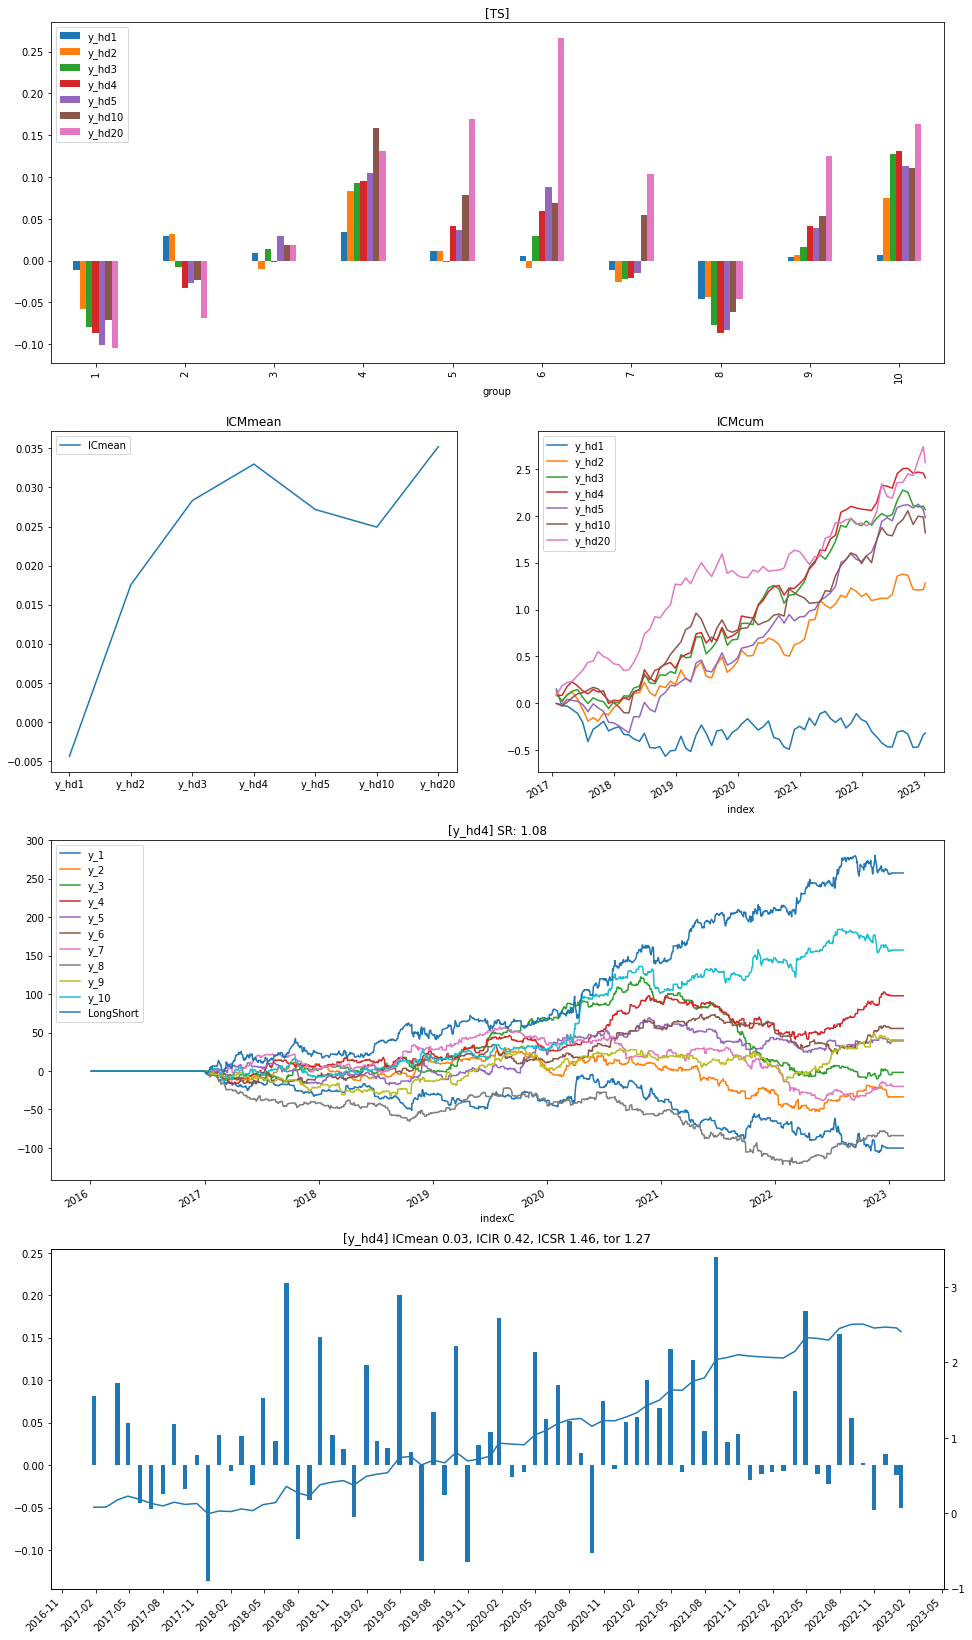

In [21]:
ydf_dict = {}
for yp in [1,2,3,4,5,10,20]:
    ydf_dict['y_hd%d'%yp] = 100.0*(data_zl['C_1'].shift(-yp)/data_zl['C_1']-1)-100.0*(data_zl['C_2'].shift(-yp)/data_zl['C_2']-1)

C = data_zl['ret'].copy()
if_jy = data_zl['if_jy'].copy()

y_show = 'y_hd4'

cuts = 10
ifqcut = True
startdate = datetime.datetime(2017,1,1)
enddate = datetime.datetime(2019,1,1)


factordf1 = -MIv[MIv.index > startdate].rolling(1).sum()
factordf2 = MIu[MIu.index > startdate].rolling(1).sum()
factordf =  factordf1

a,b,npsdf_ts_sig_1,nfactordf_ts_sig_1 = mltool.FactorPerform_TSS(factordf, ydf_dict, y_show, if_jy, cuts, ifqcut, startdate, enddate, nameflag_='[TS]', scomms=[], plt_groups=[], if_plot_all=False, if_plot_ls=True, if_savefig=False, figpath=figpath)

In [23]:
factors_index = Factor_index(data_index_)    


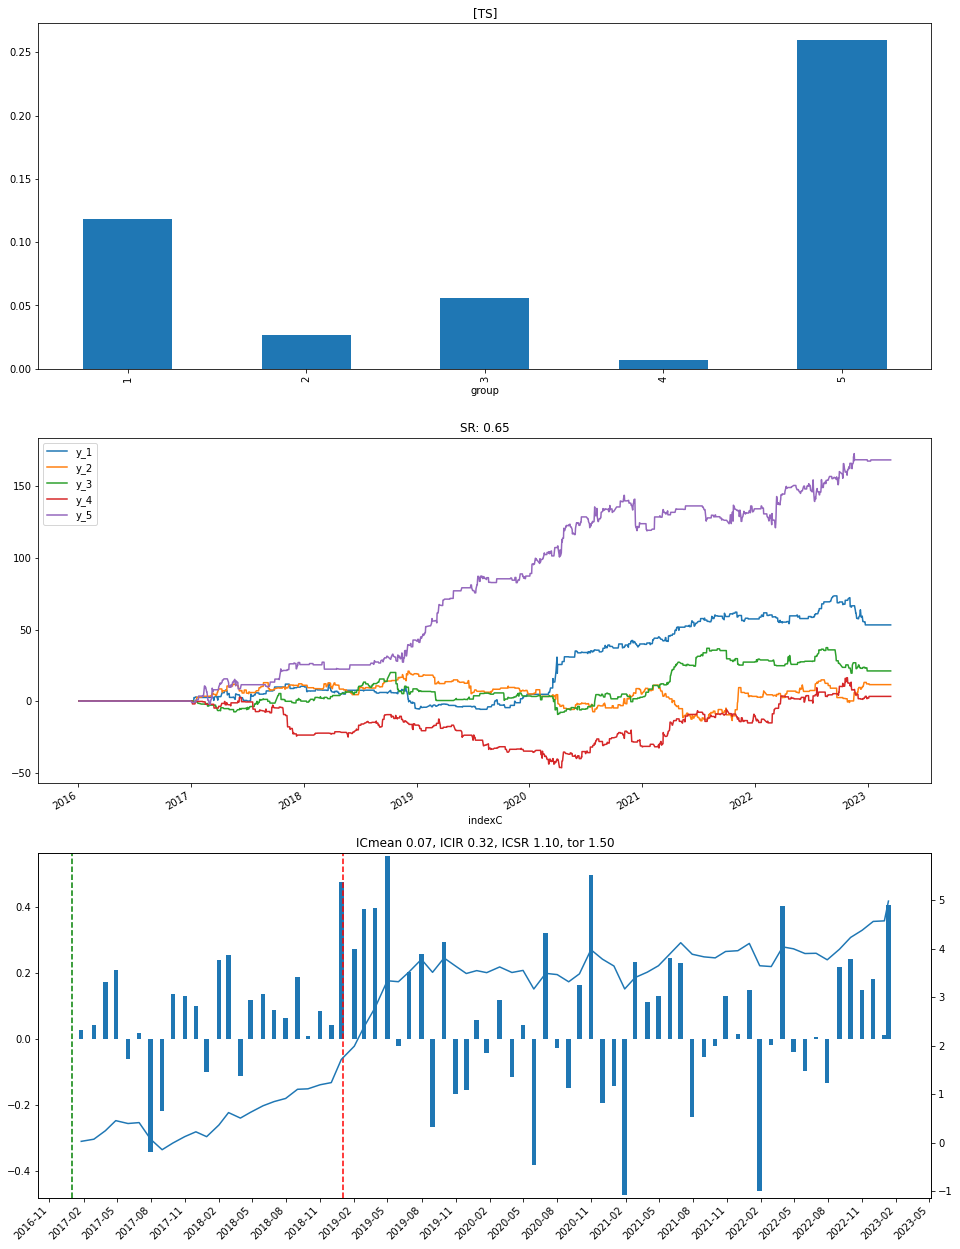

In [25]:
factor_1_trade,name = factors_index.MeanMa(xp=128)
#factor_1_trade,name = factors_index.ma_ratio(xp=8,window=10)

ydf = ydf_dict['y_hd4'].copy()
tradedf = (nfactordf_ts_sig_1==10)*ydf - (nfactordf_ts_sig_1==1)*ydf
tradedf[tradedf==0] = np.nan


factordf = factor_1_trade

cuts = 5

a,b,npsdf_ts_trade_1,nfactordf_ts_trade_1 = mltool.FactorPerform_TS(factordf, tradedf, if_jy, cuts, ifqcut, startdate, enddate, nameflag_='[TS]', scomms=[], plt_groups=[], if_plot_all=False, if_plot_ls=False, if_savefig=False, figpath=figpath)

In [26]:
pairs_ps_1 = (nfactordf_ts_sig_1==10)*1 - (nfactordf_ts_sig_1==1)*1
print(mltool.CalculateTur(pairs_ps_1))

pairs_ps_1 = pairs_ps_1 * (1*(nfactordf_ts_trade_1 == 5))
print(mltool.CalculateTur(pairs_ps_1))

pairs_ps = pairs_ps_1.rolling(4).mean()
print(mltool.CalculateTur(pairs_ps))

1.6829787234042553
1.6743827160493827
0.6222961730449251


('sr: ', 0.6040024358859214)


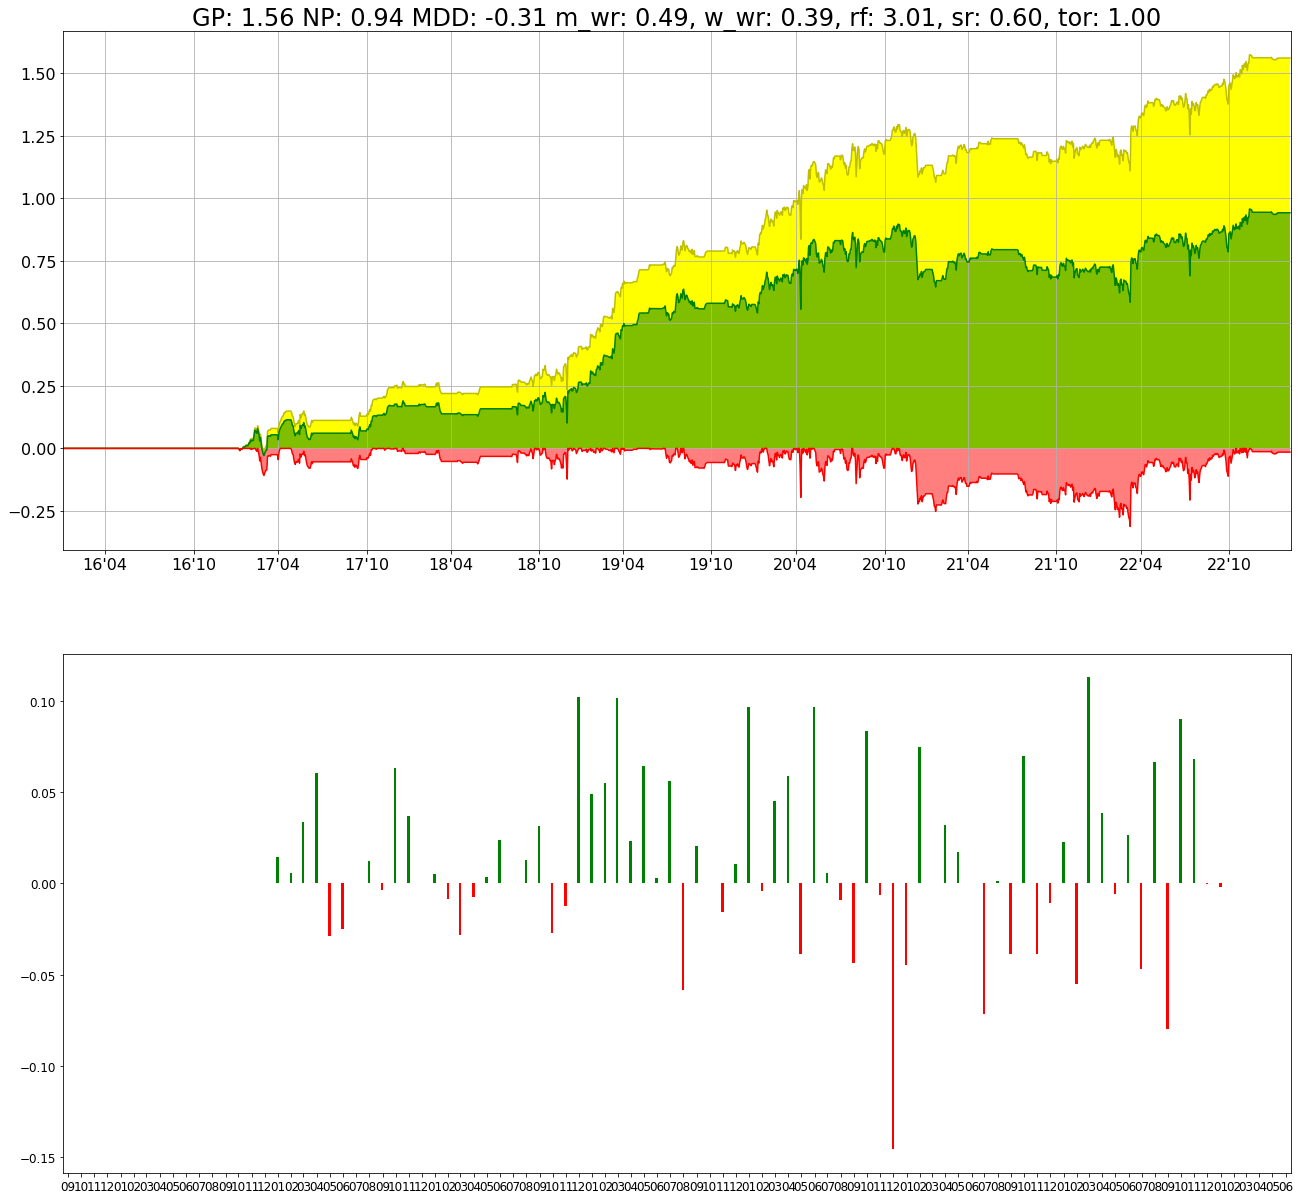

(0.6040024358859214, 1)

In [29]:
dfbkt = None

for pair in arbtwo_list:
    alpha, beta = hedge_ratio(pair.ratio1*(data_zl_day['C'][pair.symbol1]),pair.ratio2*(data_zl_day['C'][pair.symbol2]),period=21*6,maperiod=1)
    beta = 1
    dfbkt_ = ArbBacktest_roll((pairs_ps[pair.name],pair), data_zl_day, beta,cost_penalty=1)
    
    # dfbkt_ = ArbBacktest((pairs_ps[pair.name],pair), data_zl_day,cost_penalty=1)
    

    if  dfbkt is None:
        dfbkt = dfbkt_
    else:
        dfbkt =  dfbkt_ + dfbkt
    # comms_bkt = []
    # mltool.PlotPerformance(dfbkt_, comms_bkt, figpath, nameflag_='BKT-average', enddate=datetime.datetime(2016,1,1))
dfbkt = dfbkt/ len(arbtwo_list)
comms_bkt = []
mltool.PlotPerformance(dfbkt, comms_bkt, figpath, nameflag_='BKT-average', enddate=datetime.datetime(2016,1,1))